In [1]:
import spacy
import nltk
import os

In [2]:
data = {}
documents = []

for folder in os.listdir('data'):
    for file in os.listdir('data/' + folder):
        with open('data/' + folder + '/' + file, 'r', encoding="utf-8") as f:
            data[file] = f.read()

In [3]:
import contractions
import re
import spacy
import nltk

!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
# don't remove stopwords that could impact the model
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     --------------------------------------- 12.8/12.8 MB 14.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub('(<[\w\s]*/?>)', "", text)
    text = contractions.fix(text)
    text = re.sub('[^a-zA-Z0-9\s]+', "", text)
    text = re.sub('\d+', "", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.tag_ != 'PUNCT']
    text = ' '.join([token for token in tokens if token not in stopwords])
    text = re.sub('\s+', " ", text)
    return text

for key in data.keys():
    data[key] = preprocess(data[key])

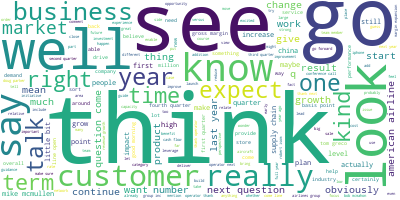

In [6]:
from wordcloud import WordCloud

long_string = ','.join(list(data.values()))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [13]:
import gensim.corpora as corpora

data_words = [doc.split() for doc in data.values()]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 179), (1, 2), (2, 1), (3, 3), (4, 5), (5, 1), (6, 10), (7, 3), (8, 9), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 5), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 14), (21, 6), (22, 1), (23, 4), (24, 1), (25, 1), (26, 20), (27, 6), (28, 1), (29, 5)]


In [17]:
from pprint import pprint
import gensim
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"I" + 0.012*"quarter" + 0.010*"year" + 0.009*"think" + 0.009*"not" + '
  '0.008*"go" + 0.007*"see" + 0.006*"thank" + 0.006*"question" + '
  '0.006*"growth"'),
 (1,
  '0.020*"I" + 0.009*"not" + 0.009*"go" + 0.009*"year" + 0.009*"question" + '
  '0.008*"quarter" + 0.008*"see" + 0.007*"think" + 0.007*"thank" + '
  '0.006*"customer"'),
 (2,
  '0.020*"I" + 0.011*"year" + 0.011*"quarter" + 0.010*"think" + 0.010*"not" + '
  '0.009*"go" + 0.009*"see" + 0.007*"thank" + 0.006*"growth" + '
  '0.006*"customer"'),
 (3,
  '0.026*"I" + 0.011*"quarter" + 0.010*"not" + 0.009*"year" + 0.009*"go" + '
  '0.008*"think" + 0.008*"see" + 0.008*"thank" + 0.006*"growth" + '
  '0.006*"question"')]


In [18]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

e:\Ebay_K\Top2Vec\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.002795 -0.001698       1        1  39.453373
2     -0.000980  0.001444       2        1  21.344692
1      0.002946 -0.001673       3        1  20.092906
0      0.000829  0.001927       4        1  19.109029, topic_info=          Term         Freq        Total Category  logprob  loglift
950    quarter  5140.000000  5140.000000  Default  30.0000  30.0000
1192     think  4199.000000  4199.000000  Default  29.0000  29.0000
1295      year  4763.000000  4763.000000  Default  28.0000  28.0000
953   question  3099.000000  3099.000000  Default  27.0000  27.0000
504         go  4280.000000  4280.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
972     really   420.765952  2393.770550   Topic4  -5.3994  -0.0835
1291     would   397.224487  2307.333709   Topic4  -5.4570  -0.1043
1272      well   412.281698  2561.337929   Topic4  -5.4198  -0.1716
53        also   343.428801  1913.897602   Topic4  -5.6025  -0.0629
217       come   346.685711  2134.262904   Topic4  -5.5931  -0.1624

[387 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.463188        I
0         2  0.193672        I
0         3  0.178795        I
0         4  0.164283        I
2063      1  0.371437  advance
...     ...       ...      ...
1301      4  0.157181     york
1302      1  0.342757     yous
1302      2  0.284362     yous
1302      3  0.180265     yous
1302      4  0.190421     yous

[1045 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])